<a href="https://colab.research.google.com/github/KBVKarthik/Keras-Computer-Vision-Models/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 679 kB 4.9 MB/s 


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [14]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169009152/169001437 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [15]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  
patch_size = 6  
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
transformer_layers = 8
mlp_head_units = [2048, 1024] 

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(x_train)


In [17]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [18]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


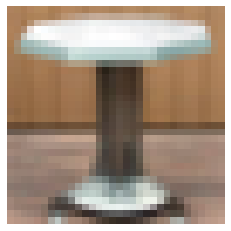

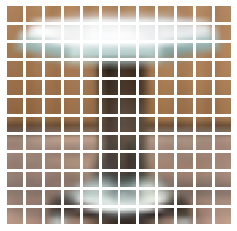

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [20]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [21]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)

    augmented = data_augmentation(inputs)

    patches = Patches(patch_size)(augmented)

    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)


    for _ in range(transformer_layers):

        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        encoded_patches = layers.Add()([x3, x2])


    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [23]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=5,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/5
176/176 [==============================] - 161s 844ms/step - loss: 4.4513 - accuracy: 0.0513 - top-5-accuracy: 0.1719 - val_loss: 3.9606 - val_accuracy: 0.1010 - val_top-5-accuracy: 0.3074
Epoch 2/5
176/176 [==============================] - 147s 834ms/step - loss: 3.9230 - accuracy: 0.0982 - top-5-accuracy: 0.2994 - val_loss: 3.5463 - val_accuracy: 0.1636 - val_top-5-accuracy: 0.4222
Epoch 3/5
176/176 [==============================] - 147s 834ms/step - loss: 3.6629 - accuracy: 0.1364 - top-5-accuracy: 0.3772 - val_loss: 3.3124 - val_accuracy: 0.2088 - val_top-5-accuracy: 0.4844
Epoch 4/5
176/176 [==============================] - 147s 834ms/step - loss: 3.4924 - accuracy: 0.1660 - top-5-accuracy: 0.4260 - val_loss: 3.1393 - val_accuracy: 0.2324 - val_top-5-accuracy: 0.5266
Epoch 5/5
313/313 [==============================] - 15s 48ms/step - loss: 2.9814 - accuracy: 0.2630 - top-5-accuracy: 0.5643
Test accuracy: 26.3%
Test top 5 accuracy: 56.43%
